In [11]:
# LIB IMPORTS
import os
import datetime as dt

from coropy.growth_models import GrowthCOVIDModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import plotting


# DATA LOAD
DATA_DIR = 'data'
FILE_NAMES = ['initial_timeseries_SEIRD.csv',
              '2nd_wave_timeseries_SEIRD.csv']
FILE_PATHS = [os.path.join(os.pardir, DATA_DIR, FILE_NAMES[0]),
              os.path.join(os.pardir, DATA_DIR, FILE_NAMES[1])]
df_1 = pd.read_csv(FILE_PATHS[0])
df_2 = pd.read_csv(FILE_PATHS[1])
df = pd.concat([df_1, df_2[1:-1]], sort=False)

cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
active = cum_positives - cum_recovered - cum_deceased

eff_dates=[dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 1), dt.datetime(2020, 8, 8)]

In [13]:
# fit the entire first wave data to a Heidler function
def heidler(t, t1, t2, n, a, b):
    exp_1 = 1 - np.exp(-t/t1)
    exp_2 = np.exp(-t/t2)
    # if np.sign is not used NumPy will generate RuntimeWarning: invalid value encountered in power
    # https://stackoverflow.com/questions/45384602/numpy-runtimewarning-invalid-value-encountered-in-power#45384691
    return a/b * np.sign(exp_1) * (np.abs(exp_1))**n * exp_2  

In [27]:
X = []
Y = []

# past wave(s)
start_idx = 0
for start_date, end_date in zip(eff_dates[:-1], eff_dates[1:]):
    end_idx = start_idx+abs((end_date - start_date).days)
    
    model = GrowthCOVIDModel(heidler, normalize=True, calc_ci=False)
    model.fit(active[start_idx:end_idx])
    x, fitted = model.get_fitted
    X.append(x)
    Y.append(fitted)
    
    start_idx = end_idx  # update indexing

# current wave   
model = GrowthCOVIDModel(heidler, normalize=True, calc_ci=False)
model.fit(active[start_idx:])
x, fitted = model.get_fitted
X.append(x)
Y.append(fitted)

/home/alk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in power
  import sys
/home/alk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


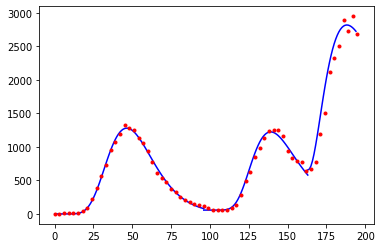

In [39]:
plt.plot(X[0], Y[0], 'b')
plt.plot(X[1] + X[0][-1], Y[1], 'b')
plt.plot(X[2] + X[0][-1] + X[1][-1], Y[2], 'b')
plt.plot(active, 'r.', markevery=3)